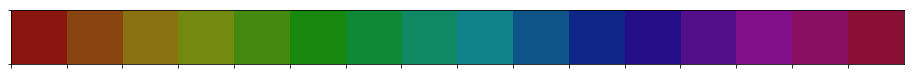

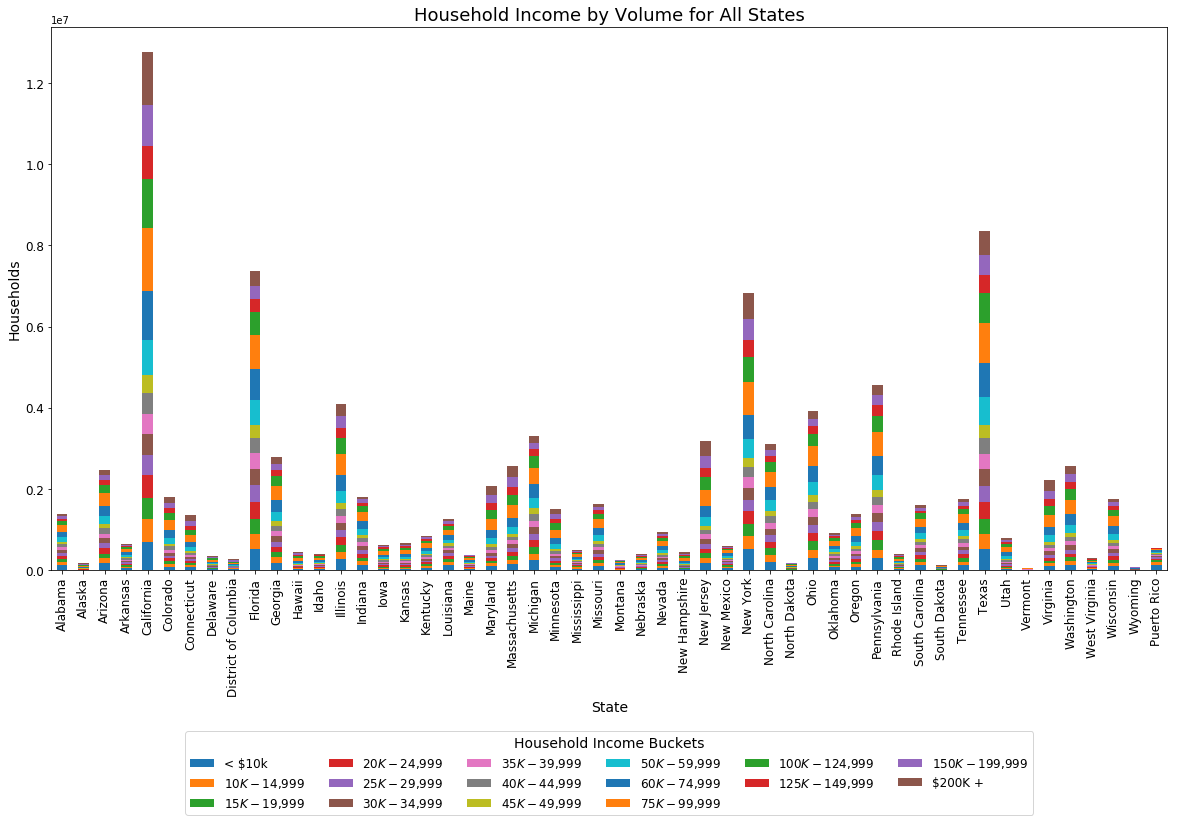

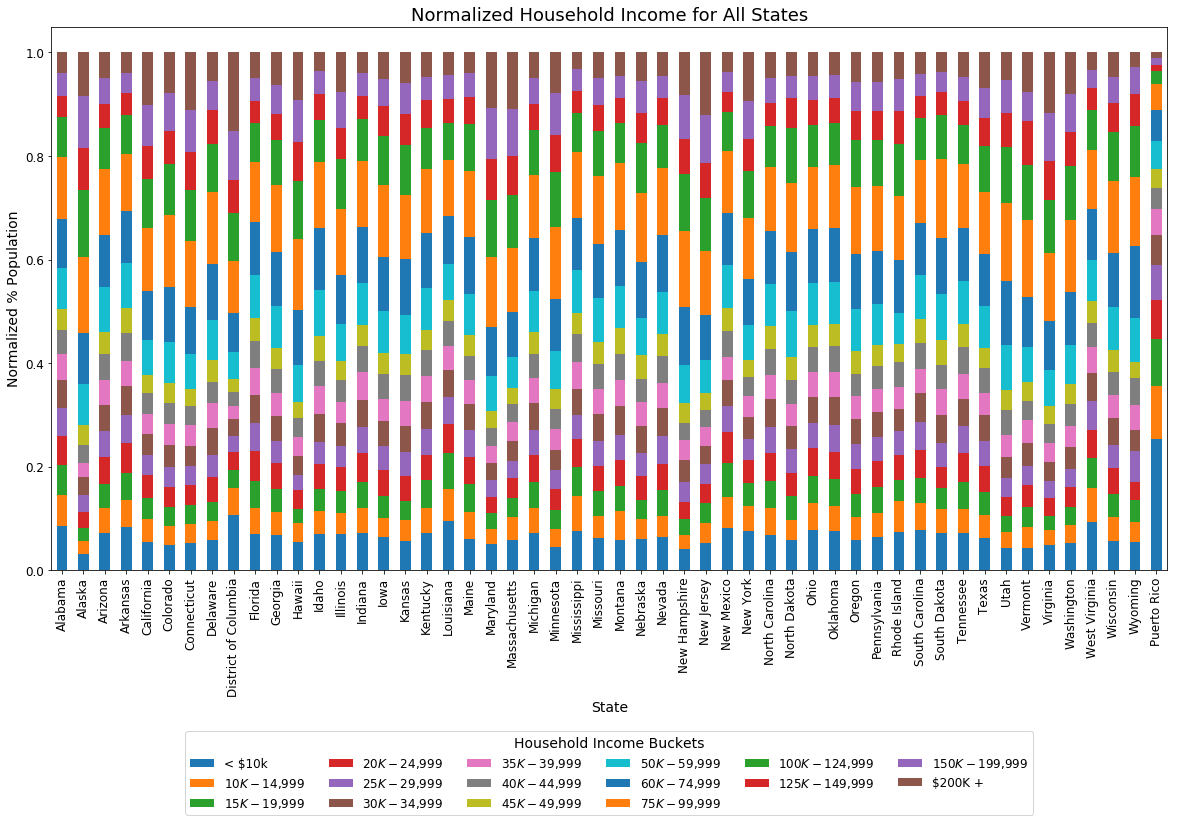

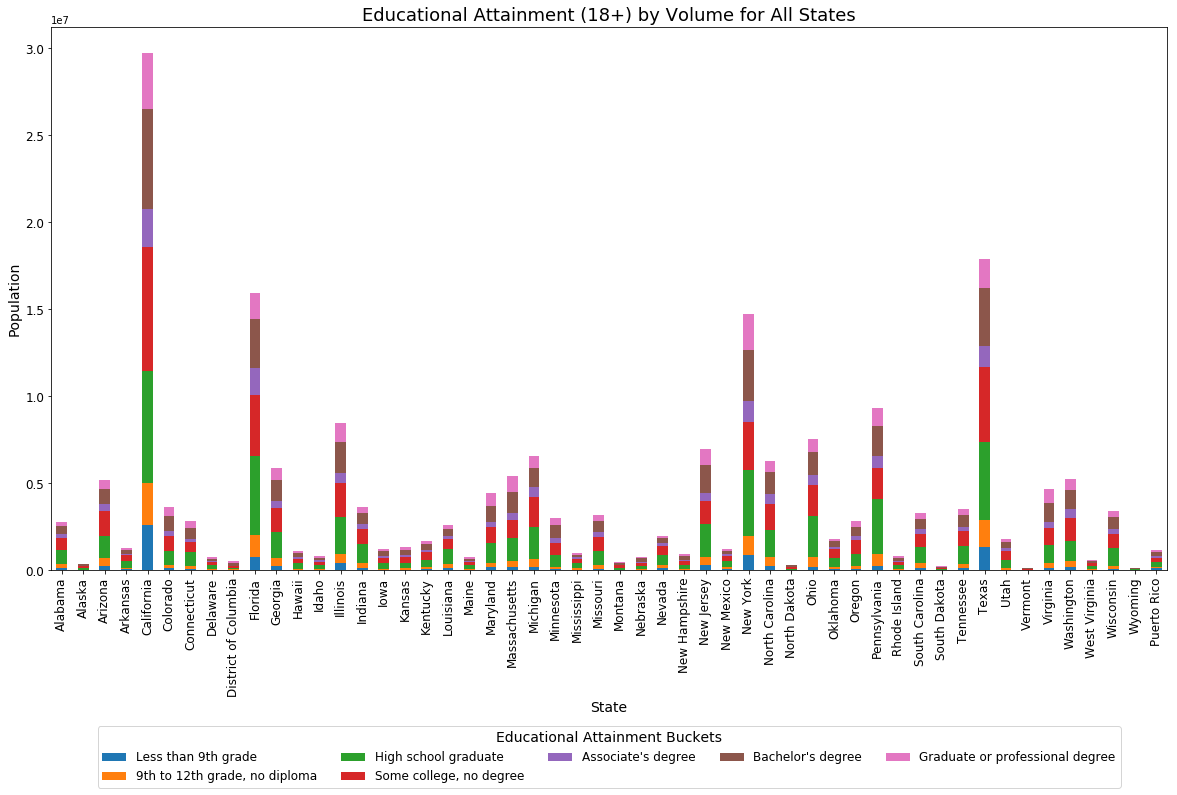

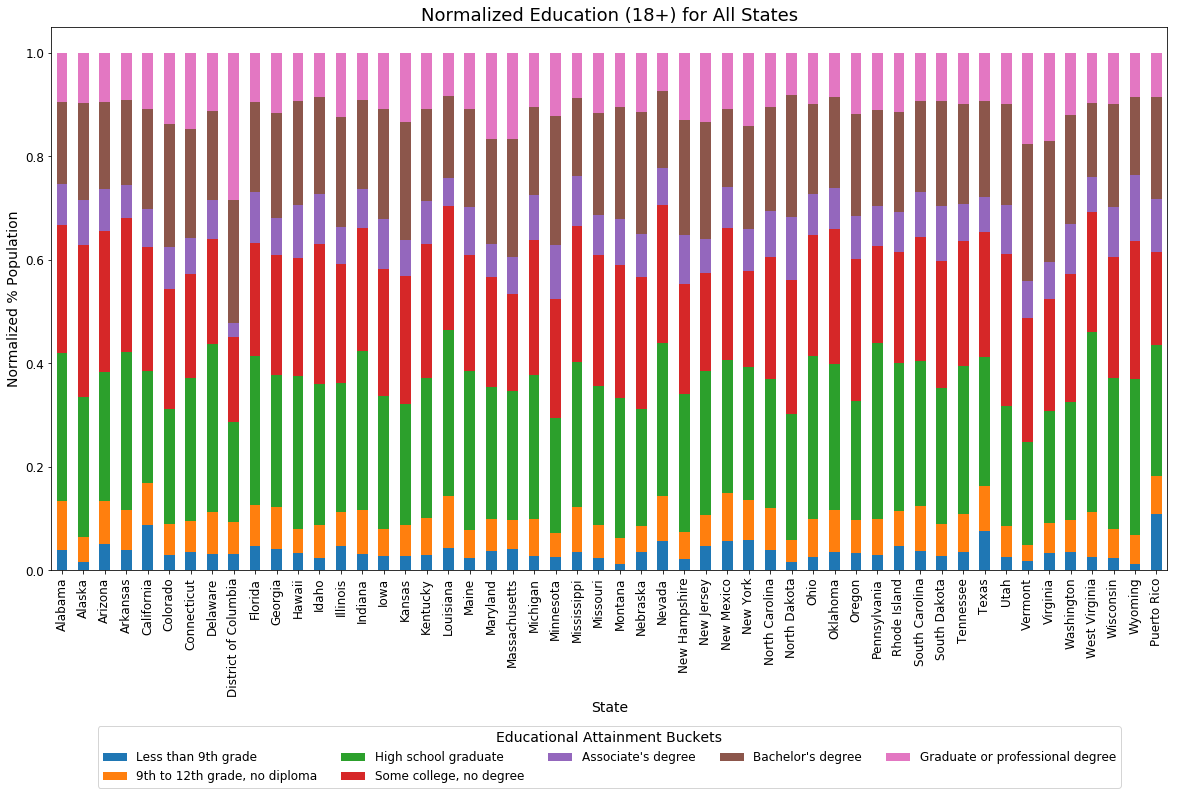

In [2]:
##NUPUR'S CODE##

# Dependencies
import requests as req
import numpy as np
import json
import pandas as pd
from pandas import ExcelWriter
from pandas import ExcelFile
import matplotlib.pyplot as plt
import seaborn as sns

##### MAP GEOCODES (FIPS) TO STATES/COUNTIES #####
# Create function to make Geocode Data into DataFrame
def makeGeocodeDF(pdExel,sumLevel,fipsCol1,colName,fipsCol2=0):
    # Create DF out of excel
    df = pdExel.loc[pdExel['Summary Level'] == sumLevel]

    # If the summary level is 'county'
    if sumLevel == 50:
        # Add both fips code levels
        df = df[[fipsCol1,fipsCol2,'Area Name (including legal/statistical area description)']]
    else:
        # only add one fips code level
        df = df[[fipsCol1,'Area Name (including legal/statistical area description)']]

    # Rename columns
    df = df.rename(columns={'Area Name (including legal/statistical area description)' : colName})

    # Return DataFrame
    return df

# Read excel file of geo codes
geocodeMap = pd.read_excel('resources/2015-allgeocodes.xlsx', sheetname='Sheet1')

# Create DataFrame of States/State FIPS
geocodeMapState = makeGeocodeDF(geocodeMap,40,'State Code (FIPS)','State')
# Create DataFrame of County Names/County FIPS/State FIPS/
geocodeMapCounty = makeGeocodeDF(geocodeMap,50,'County Code (FIPS)','County','State Code (FIPS)')
# Create DataFrame of States and Abbreviations
abbrMap = pd.read_excel('../Workspace/resources/stateAbbreviation.xlsx')

# Create merged DataFrame with County and State FIPS and Names
geocodeMap = pd.merge(geocodeMapState,geocodeMapCounty, how='outer', on='State Code (FIPS)')

#/ Variables/DFs to use:
    #/ For state/county mapping: geocodeMap
    #/ remember to merge on BOTH State and County (county FIPs repeat)

##### CENSUS DATA #####
#/// SETUP 'GET' Variables \\\#
# Function to dynamically create variable ID lists
def createIdList(r1,r2,s,avoid=[]): #range start, range stop, id string, avoid ids (optional)

    i = [] # List variable

    # For all variables in the range
    for x in range(r1,r2):

        # If there are variables to avoid, pass
        if x in avoid:
            pass

        # If id is greater than 9
        elif x > 9:
            i.append(s+str(x)+'E')

        # Add a leading zero for IDs below 10
        else:
            i.append(s+'0'+str(x)+'E')

    # Return list
    return i

# Function to create a dictionary of IDs and their string
def createIdDict(k,v):

    n = 0 #counter
    d = {} #dictionary

    # For each ID in list
    for x in k:

        # Add it as a key and add appropriate bucket as value
        d[x] = v[n%len(v)] #use remainder to determine bucket (if it loops)
        n += 1 # Increase counter

    # Rename state/county to match geomap
    d['state'] = 'State Code (FIPS)'
    d['county'] = 'County Code (FIPS)'

    # Return Dictionary
    return d

# HOUSEHOLD INCOME: Create List and Dictionary
householdIncomeIdList = createIdList(2,18,'B19001_0')
householdIncomeBuckets = ['< $10k',
                          '$10K - $14,999',
                          '$15K - $19,999',
                          '$20K - $24,999',
                          '$25K - $29,999',
                          '$30K - $34,999',
                          '$35K - $39,999',
                          '$40K - $44,999',
                          '$45K - $49,999',
                          '$50K - $59,999',
                          '$60K - $74,999',
                          '$75K - $99,999',
                          '$100K - $124,999',
                          '$125K - $149,999',
                          '$150K - $199,999',
                          '$200K +']
householdIncomeDict = createIdDict(householdIncomeIdList,householdIncomeBuckets)

# EDUCATIONAL ATTAINMENT: Create List and Dictionary
notInclude = [1,2,3,11,19,27,35,43,44,52,60,68,76] #id's not to include in list
educationIdList = createIdList(1,84,'B15001_0',notInclude)
educationAttainmentBuckets = ['Less than 9th grade',
                              '9th to 12th grade, no diploma',
                              'High school graduate',
                              'Some college, no degree',
                              'Associate\'s degree',
                              'Bachelor\'s degree',
                              'Graduate or professional degree']
educationDict = createIdDict(educationIdList,educationAttainmentBuckets)
# Split education list in 2 because of 50 variable arg max
educationIdList1 = educationIdList[:int(len(educationIdList)/2)]
educationIdList2 = educationIdList[int(len(educationIdList)/2):]

# POPULATION: Create Dictionary
populationDict = createIdDict(['B01001_001E'],['Population'])

# Create string of ID's to query
idLists = [householdIncomeIdList,educationIdList1,educationIdList2] # List of lists
getArgs = []

# Create list of get arguments (all id's)
for l in idLists:

    getIds = '' #string

    # For all IDs in the list
    for i in l:

        getIds = getIds + i + ',' #add ID to final string

    getIds = getIds[:-1] #remove last comma
    getArgs.append(getIds) #add to ID list

# Append population to get args
getArgs.append((list(populationDict.keys()))[0])

#/// Setup Query URL \\\#
# Variables
year = 2016
apiKey = 'a9bba28cbc522f8f9d8ae3b88ef030fba6034516'
baseURL = 'https://api.census.gov/data/{}/acs/acs1/'.format(year)
forArgs = 'county:*'

# Create list of URLs to query
urlList = [] #empty list
for x in getArgs:
    URLArgs = '?get={}&for={}&key={}'.format(x,forArgs,apiKey)
    queryURL = baseURL + URLArgs
    urlList.append(queryURL)


#/// Create Dataframes \\\#
# Create function
def makeDataFrame(url,labelDict):

    #Get response data from API
    response = req.get(url)
    jsonData = response.json() #create json

    # Create data frame from json
    df = pd.DataFrame(jsonData, columns=jsonData[0]) #rename headers with first row values
    df = df.rename(columns=labelDict) #rename columnns using associated dictionary
    df = df.drop(df.index[0]) #remove first row

    # Remove leading zeros from state and county
    df['State Code (FIPS)'] = df['State Code (FIPS)'].str.lstrip('0')
    df['County Code (FIPS)'] = df['County Code (FIPS)'].str.lstrip('0')

    # Make all numbers in DF numeric
    df = df.apply(pd.to_numeric)

    return df

# Make DF using Function
incomeDF = makeDataFrame(urlList[0],householdIncomeDict)
eduDF1 = makeDataFrame(urlList[1],educationDict)
eduDF2 = makeDataFrame(urlList[2],educationDict)
populationDF = makeDataFrame(urlList[3],populationDict)

#/// Merge Education DataFrames \\\#
# Create joint DF
eduDF = pd.merge(eduDF1,eduDF2,how='outer',on=['State Code (FIPS)','County Code (FIPS)'])

# Create dictionary to remove appeneded X's and Y's on column names
removeAppend = {}
for i in educationAttainmentBuckets:
    s1 = i + '_x'
    s2 = i + '_y'
    removeAppend[s1] = i
    removeAppend[s2] = i

# Rename column headers
eduDF = eduDF.rename(columns=removeAppend)

# Sum columns with same names in DF
eduDF = eduDF.groupby(lambda x:x, axis=1).sum()

#/// Map Geocodes and add to DF \\\#
# Create function to automate
def mergeOnGeocode(df1,df2):
    try:
        return pd.merge(df1,df2,how='inner',on=['State Code (FIPS)','County Code (FIPS)'])
    except:
        return pd.merge(df1,df2,how='inner',on=['State Code (FIPS)'])


# Map census DFs to FIPS
incomeDFmapped = mergeOnGeocode(incomeDF,geocodeMap)
eduDFmapped = mergeOnGeocode(eduDF,geocodeMap)

popDFmapped = mergeOnGeocode(populationDF,geocodeMap)
popDFmapped = pd.merge(popDFmapped,abbrMap, how='inner',on=['State'])

#/ Variables/DFs to use:
    #/ To normalize data, use this DF: popDFmapped (FIPS mapped to names)
    #/ Income data DF to use: incomeDFmapped (FIPS mapped to names) or incomeDF (FIPS only)
    #/ Education data DF to use: eduDFmapped (FIPS mapped to names) or eduDF (FIPS only)

#/// Create Normalized DFs \\\*

# Create function to normalize data
def normalizeData(df1,df2,buckets):

    # Merge dicts on geocode
    df = mergeOnGeocode(df1,df2)

    # For each column, divide by the total population column
    for bucket in buckets:
        df[bucket] = df[bucket]/df['Population']

    # Drop population column
    df.drop(['Population'], axis=1, inplace=True)

    # Return df
    return df

# HOUSEHOLDS TOTAL: Create DF
var = 'B19001_001E'
householdDict = createIdDict([var],['Population']) #create dict

URLArgs = '?get={}&for={}&key={}'.format(var,forArgs,apiKey)
queryURL = baseURL + URLArgs #put together query URL

householdDF = makeDataFrame(queryURL,householdDict) #create DF

# +18 POPULATION TOTAL: Create DF
var = 'B15001_001E'
over18Dict = createIdDict([var],['Population']) #create dict

URLArgs = '?get={}&for={}&key={}'.format(var,forArgs,apiKey)
queryURL = baseURL + URLArgs #put together query URL

over18DF = makeDataFrame(queryURL,over18Dict) #create DF

# Normalize Income and Education DFs
normIncome = normalizeData(incomeDF,householdDF,householdIncomeBuckets) #normalizedIncome
normEdu = normalizeData(eduDF,over18DF,educationAttainmentBuckets) #normalizedEdu

#/// Create Normalized DFs for States \\\*

# Function to breakdown DFs by state FIPS
def breakdownByState(dfIn):
    df = dfIn.groupby(['State Code (FIPS)']).sum()
    df.drop(['County Code (FIPS)'], axis=1, inplace=True)
    df = df.reset_index()
    return df

# Function to set state as index
def setStateAsIndex(df):

    # Merge on state only
    df = mergeOnGeocode(df,geocodeMapState)
    df.drop('State Code (FIPS)', axis=1, inplace=True)
    df = df.set_index('State')
    return df

# Function to Normalize state DFs
def createStateNormDF (df1,df2,buckets):

    # Breakdown DFs by STate and Normalize
    df1n = breakdownByState(df1)
    df2n = breakdownByState(df2)
    df = normalizeData(df1n,df2n,buckets)

    # Set state as the index
    df = setStateAsIndex(df)

    return df

# Create State DF's
# Income
incomeByState = setStateAsIndex(breakdownByState(incomeDF))
incomeByState = incomeByState[householdIncomeBuckets] #reorder columns
# Education
eduByState = setStateAsIndex(breakdownByState(eduDF))
eduByState = eduByState[educationAttainmentBuckets] #reorder columns

# Create State Normalized DF's
# Income
incomeByStateNorm = createStateNormDF(incomeDF,householdDF,householdIncomeBuckets)
incomeByStateNorm = incomeByStateNorm[householdIncomeBuckets] #reorder columns
# Education
eduByStateNorm = createStateNormDF(eduDF,over18DF,educationAttainmentBuckets)
eduByStateNorm = eduByStateNorm[educationAttainmentBuckets] #reorder columns

#/// Create Bar Charts \\\*
sns.palplot(sns.hls_palette(16, l=.3, s=.8))

# Function to create bar charts
def createBarChart(df,title,x,y,lt,l,c):

    # Plot DF as bar graph
    df.plot(kind='bar',
            stacked=True,
            title=title,
            figsize=(20,10),
            fontsize=14
           )

    # Add title/labels
    plt.title(title,fontsize=18) #Create graph title
    plt.xlabel(x, fontsize=14) #Create x-axis label
    plt.ylabel(y,fontsize=14) #Create y-axis label
    plt.tick_params(axis='both', labelsize=12) #Format Axis

    # Add legend
    legend = plt.legend(loc='lower center',bbox_to_anchor=(.5, l), ncol=c, borderaxespad=0., title=lt, fontsize=12)
    legend.get_title().set_fontsize('14') #Set legend title font size

    # Show plot
    plt.show()

# Bar Chart: Household Income for All States
createBarChart(incomeByState,'Household Income by Volume for All States','State','Households','Household Income Buckets',-.45,6)

# Normalized Household Income for All States
createBarChart(incomeByStateNorm,'Normalized Household Income for All States','State','Normalized % Population','Household Income Buckets',-.45,6)

# Educational Attainment (18+) for All States
createBarChart(eduByState,'Educational Attainment (18+) by Volume for All States','State','Population','Educational Attainment Buckets',-.4,5)

# Normalized Education (18+) for All States
createBarChart(eduByStateNorm,'Normalized Education (18+) for All States','State','Normalized % Population','Educational Attainment Buckets',-.4,5)

In [3]:
res_data = pd.ExcelFile('../Workspace/DataDownload.xls')
restaurant_df = pd.read_excel(res_data, 'RESTAURANTS')
restaurant_df.head()

,FIPS,State,County,FFR09,FFR14,PCH_FFR_09_14,FFRPTH09,FFRPTH14,PCH_FFRPTH_09_14,FSR09,FSR14,PCH_FSR_09_14,FSRPTH09,FSRPTH14,PCH_FSRPTH_09_14,PC_FFRSALES07,PC_FFRSALES12,PC_FSRSALES07,PC_FSRSALES12
0,1001,AL,Autauga,30,36,20.000000,0.554170,0.649878,17.270512,34,29,-14.705882,0.628059,0.523513,-16.645960,649.511367,674.80272,484.381507,512.280987
1,1003,AL,Baldwin,112,132,17.857143,0.624282,0.659634,5.662750,202,221,9.405941,1.125938,1.104387,-1.914027,649.511367,674.80272,484.381507,512.280987
2,1005,AL,Barbour,21,22,4.761905,0.759301,0.818239,7.762116,12,15,25.000000,0.433887,0.557890,28.579797,649.511367,674.80272,484.381507,512.280987
3,1007,AL,Bibb,7,5,-28.571429,0.305131,0.222163,-27.190844,6,5,-16.666667,0.261540,0.222163,-15.055985,649.511367,674.80272,484.381507,512.280987
4,1009,AL,Blount,24,21,-12.500000,0.418549,0.363832,-13.073035,19,15,-21.052632,0.331351,0.259880,-21.569656,649.511367,674.80272,484.381507,512.280987


In [9]:
restaurant_df = restaurant_df.rename(columns={'FFR09':'Fast Food Restaurants 2009',
                                              'FFR14':'Fast Food Restaurants 2014',
                                              'PCH_FFR_09_14':'Fast-food restaurants (% change)',
                                              'FFRPTH09':'Fast-food restaurants/1,000 pop 2009',
                                              'FFRPTH14':'Fast-food restaurants/1,000 pop 2014',
                                              'PCH_FFRPTH_09_14':'Fast-food restaurants/1,000 pop (% change)'})
restaurant_df.head()

,FIPS,State,County,Fast Food Restaurants 2009,Fast Food Restaurants 2014,Fast-food restaurants (% change),"Fast-food restaurants/1,000 pop 2009","Fast-food restaurants/1,000 pop 2014","Fast-food restaurants/1,000 pop (% change)",FSR09,FSR14,PCH_FSR_09_14,FSRPTH09,FSRPTH14,PCH_FSRPTH_09_14,PC_FFRSALES07,PC_FFRSALES12,PC_FSRSALES07,PC_FSRSALES12
0,1001,AL,Autauga,30,36,20.000000,0.554170,0.649878,17.270512,34,29,-14.705882,0.628059,0.523513,-16.645960,649.511367,674.80272,484.381507,512.280987
1,1003,AL,Baldwin,112,132,17.857143,0.624282,0.659634,5.662750,202,221,9.405941,1.125938,1.104387,-1.914027,649.511367,674.80272,484.381507,512.280987
2,1005,AL,Barbour,21,22,4.761905,0.759301,0.818239,7.762116,12,15,25.000000,0.433887,0.557890,28.579797,649.511367,674.80272,484.381507,512.280987
3,1007,AL,Bibb,7,5,-28.571429,0.305131,0.222163,-27.190844,6,5,-16.666667,0.261540,0.222163,-15.055985,649.511367,674.80272,484.381507,512.280987
4,1009,AL,Blount,24,21,-12.500000,0.418549,0.363832,-13.073035,19,15,-21.052632,0.331351,0.259880,-21.569656,649.511367,674.80272,484.381507,512.280987


In [10]:
fast_food_df=restaurant_df[['FIPS',
                            'State',
                            'County',
                            'Fast Food Restaurants 2009',
                            'Fast Food Restaurants 2014',
                            'Fast-food restaurants (% change)',
                            'Fast-food restaurants/1,000 pop 2009',
                            'Fast-food restaurants/1,000 pop 2014',
                            'Fast-food restaurants/1,000 pop (% change)']].copy()
fast_food_df.head()

,FIPS,State,County,Fast Food Restaurants 2009,Fast Food Restaurants 2014,Fast-food restaurants (% change),"Fast-food restaurants/1,000 pop 2009","Fast-food restaurants/1,000 pop 2014","Fast-food restaurants/1,000 pop (% change)"
0,1001,AL,Autauga,30,36,20.000000,0.554170,0.649878,17.270512
1,1003,AL,Baldwin,112,132,17.857143,0.624282,0.659634,5.662750
2,1005,AL,Barbour,21,22,4.761905,0.759301,0.818239,7.762116
3,1007,AL,Bibb,7,5,-28.571429,0.305131,0.222163,-27.190844
4,1009,AL,Blount,24,21,-12.500000,0.418549,0.363832,-13.073035


In [195]:
# fast_food_df.insert(loc=0,column='Yearly Growth Rate %',value=int)
# fast_food_df.head()
# fast_food_df.insert(loc=0,column='Fast Food Restaurants 2015 (PROJECTED)',value=int)
# fast

,Yearly Growth Rate %,FIPS,State,County,Fast Food Restaurants 2009,Fast Food Restaurants 2014,Fast-food restaurants (% change),"Fast-food restaurants/1,000 pop 2009","Fast-food restaurants/1,000 pop 2014","Fast-food restaurants/1,000 pop (% change)"
0,<class 'int'>,1001,AL,Autauga,30,36,20.000000,0.554170,0.649878,17.270512
1,<class 'int'>,1003,AL,Baldwin,112,132,17.857143,0.624282,0.659634,5.662750
2,<class 'int'>,1005,AL,Barbour,21,22,4.761905,0.759301,0.818239,7.762116
3,<class 'int'>,1007,AL,Bibb,7,5,-28.571429,0.305131,0.222163,-27.190844
4,<class 'int'>,1009,AL,Blount,24,21,-12.500000,0.418549,0.363832,-13.073035


In [11]:
# fast_food_df.insert(loc=0,column='Yearly Growth Rate %',value=int)

ff_df=fast_food_df[['FIPS',
                    'State',
                    'County',
                    'Fast Food Restaurants 2009',
                    'Fast Food Restaurants 2014',
                    'Fast-food restaurants (% change)',
                    'Fast-food restaurants/1,000 pop 2009',
                    'Fast-food restaurants/1,000 pop 2014',
                    'Fast-food restaurants/1,000 pop (% change)']].copy()
ff_df.head()

,FIPS,State,County,Fast Food Restaurants 2009,Fast Food Restaurants 2014,Fast-food restaurants (% change),"Fast-food restaurants/1,000 pop 2009","Fast-food restaurants/1,000 pop 2014","Fast-food restaurants/1,000 pop (% change)"
0,1001,AL,Autauga,30,36,20.000000,0.554170,0.649878,17.270512
1,1003,AL,Baldwin,112,132,17.857143,0.624282,0.659634,5.662750
2,1005,AL,Barbour,21,22,4.761905,0.759301,0.818239,7.762116
3,1007,AL,Bibb,7,5,-28.571429,0.305131,0.222163,-27.190844
4,1009,AL,Blount,24,21,-12.500000,0.418549,0.363832,-13.073035


In [12]:
popDFmapped.head()


,Population,State Code (FIPS),County Code (FIPS),State,County,Abbreviation
0,208563,1,3,Alabama,Baldwin County,AL
1,114611,1,15,Alabama,Calhoun County,AL
2,82471,1,43,Alabama,Cullman County,AL
3,70900,1,49,Alabama,DeKalb County,AL
4,81799,1,51,Alabama,Elmore County,AL


In [13]:
for index,row in ff_df.iterrows():
    total_gr = row['Fast-food restaurants (% change)']
    yr_gr = total_gr/5
    ff_df.set_value(index,'Yearly Growth Rate %',yr_gr)
    ff09 = row['Fast Food Restaurants 2009']
    ff14 = row['Fast Food Restaurants 2014']
    projection = round((ff14*(yr_gr/100)) + ff14,0)
    ff_df.set_value(index,'Fast Food Restaurants 2015 (PROJECTED)',projection)
   
    
    
    
        
ff_df.head()
# del ff_df['Fast-food restaurants/1,000 pop 2009']
del ff_df['Fast-food restaurants/1,000 pop 2014']
del ff_df['Fast-food restaurants/1,000 pop (% change)']
ff_df.head()

,FIPS,State,County,Fast Food Restaurants 2009,Fast Food Restaurants 2014,Fast-food restaurants (% change),"Fast-food restaurants/1,000 pop 2009",Yearly Growth Rate %,Fast Food Restaurants 2015 (PROJECTED)
0,1001,AL,Autauga,30,36,20.000000,0.554170,4.000000,37.0
1,1003,AL,Baldwin,112,132,17.857143,0.624282,3.571429,137.0
2,1005,AL,Barbour,21,22,4.761905,0.759301,0.952381,22.0
3,1007,AL,Bibb,7,5,-28.571429,0.305131,-5.714286,5.0
4,1009,AL,Blount,24,21,-12.500000,0.418549,-2.500000,20.0


In [14]:
# ff_df['County'] = ff_df['County'] + ' County'
# ff_df['County'] = ff_df['County'].str.rstrip(' County')
# ff_df['County'] = ff_df['County'] + ' County'
ff_df.head()

,FIPS,State,County,Fast Food Restaurants 2009,Fast Food Restaurants 2014,Fast-food restaurants (% change),"Fast-food restaurants/1,000 pop 2009",Yearly Growth Rate %,Fast Food Restaurants 2015 (PROJECTED)
0,1001,AL,Autauga,30,36,20.000000,0.554170,4.000000,37.0
1,1003,AL,Baldwin,112,132,17.857143,0.624282,3.571429,137.0
2,1005,AL,Barbour,21,22,4.761905,0.759301,0.952381,22.0
3,1007,AL,Bibb,7,5,-28.571429,0.305131,-5.714286,5.0
4,1009,AL,Blount,24,21,-12.500000,0.418549,-2.500000,20.0


In [1]:
# FIPSandRes = pd.merge(ff_df,popDFmapped,how='inner',on=['County'])

# FIPSandRes.head()
# del FIPSandRes['Fast-food restaurants/1,000 pop 2009']
# del FIPSandRes['Fast-food restaurants/1,000 pop 2014']
# del FIPSandRes['Fast-food restaurants/1,000 pop (% change)']
# FIPSandRes.head(25)

In [17]:
resbystate15 = ff_df.groupby(["State"])['Fast Food Restaurants 2015 (PROJECTED)'].sum()
resbystate14 =  ff_df.groupby(["State"])['Fast Food Restaurants 2014'].sum()
resbystate15.head(20)
resbystate=pd.DataFrame({'Abbreviation':resbystate15.index,'Fast Food Restaurant Count 2014':resbystate14.values, 'Fast Food Restaurant Count 2015 (prj)':resbystate15.values}).copy()
resbystate.head()

,Abbreviation,Fast Food Restaurant Count 2014,Fast Food Restaurant Count 2015 (prj)
0,AK,429,425.0
1,AL,3561,3626.0
2,AR,1939,1963.0
3,AZ,4211,4241.0
4,CA,28292,28842.0


In [19]:
#bar chart of 2015 restaurants NOT NORMALIZED 
sns.palplot(sns.hls_palette(16, l=.3, s=.8))
plt.figure(figsize=(20,5))
x_axis = np.arange(len(resbystate))
tick_locations = [value for value in x_axis]
ff1=plt.bar(x_axis, resbystate['Restaurant Count 2015 (prj)'], width = 0.2,align='center')
ff2=plt.bar(x_axis + 0.25, resbystate['Restaurant Count 2014'], width = 0.2,align='center')

plt.xticks(tick_locations, resbystate['State'], rotation="vertical")
plt.title('Projected Restaurant Volume for 2015')
plt.xlabel('States')
plt.ylabel('Restaurant Volume')
plt.legend()
plt.tight_layout()
plt.show()

KeyError: 'Restaurant Count 2015 (prj)'

In [37]:
popDFmapped.to_csv('Populations_Per_County.csv')
# ff_df.head()

In [61]:
ff_df.head()
ff_df.rename(columns={'State':'Abbreviation'}, inplace=True)

ff_df.head()

,FIPS,Abbreviation,County,Fast Food Restaurants 2009,Fast Food Restaurants 2014,Fast-food restaurants (% change),Yearly Growth Rate %,Fast Food Restaurants 2015 (PROJECTED)
0,1001,AL,Autauga County,30,36,20.000000,4.000000,37.0
1,1003,AL,Baldwi County,112,132,17.857143,3.571429,137.0
2,1005,AL,Barbour County,21,22,4.761905,0.952381,22.0
3,1007,AL,Bibb County,7,5,-28.571429,-5.714286,5.0
4,1009,AL,Bl County,24,21,-12.500000,-2.500000,20.0


In [4]:
countypop = pd.merge(ff_df,popDFmapped,how='inner',on=['Abbreviation','County'])
countypop.head()


for index,row in countypop.iterrows():
    pop = row['Population']
    ffres14 = row['Fast Food Restaurants 2014']
    ffres15 = row['Fast Food Restaurants 2015 (PROJECTED)']
    ffpercap14 = ((ffres14/pop)*100)
    ffpercap15 = ((ffres15/pop)*100)
    ff_df.set_value(index,'Fast Food Restaurants Per Capita, 2014',ffpercap14)
    ff_df.set_value(index,'Fast Food Restaurants Per Capita, 2015',ffpercap15)
    
countypop.head()

NameError: name 'ff_df' is not defined

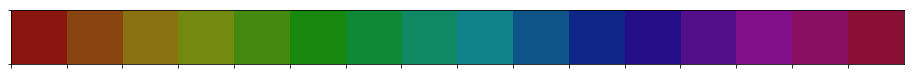

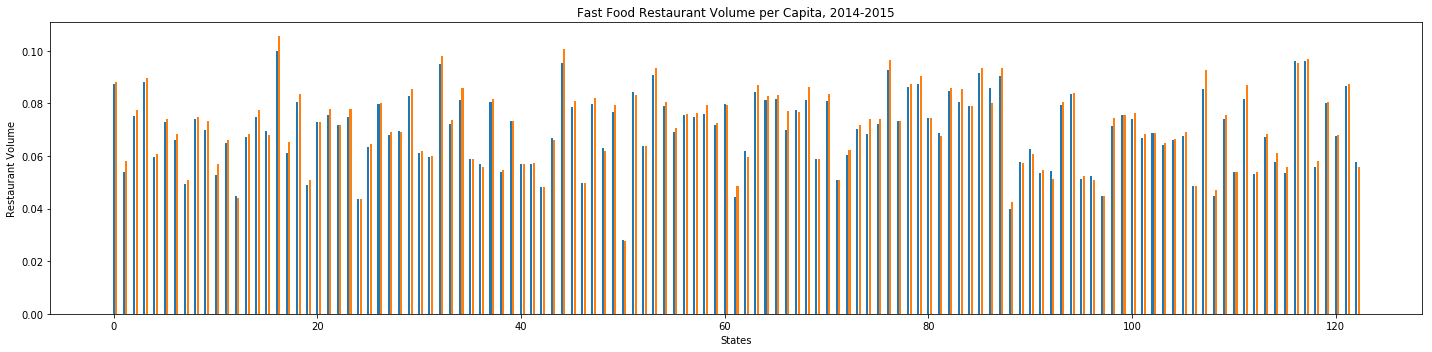

In [80]:
#Normalized bar chart  
sns.palplot(sns.hls_palette(16, l=.3, s=.8))
plt.figure(figsize=(20,5))
x_axis = np.arange(len(countypop))
tick_locations = [value for value in x_axis]
ff1=plt.bar(x_axis, countypop['Fast Food Restaurants Per Capita, 2014'], width = 0.2,align='center')
ff2=plt.bar(x_axis + 0.25, countypop['Fast Food Restaurants Per Capita, 2015'], width = 0.2,align='center')

# plt.xticks(tick_locations, countypop['Abbreviation'], rotation="vertical")
plt.title('Fast Food Restaurant Volume per Capita, 2014-2015')
plt.xlabel('States')
plt.ylabel('Restaurant Volume')
plt.legend()
plt.tight_layout()
plt.show()
